<a href="https://colab.research.google.com/github/EkaFitriRamadani/PengantarDeepLearning2022/blob/main/UTS_PengantarDeepLearning_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama Anggota Kelompok:
1. Rahmi (H071191007)
2. Eka Fitri Ramadani (H071191043)
3. Alika Oktaviani (H071191057)


Dalam tutorial ini, kita akan menerapkan dan membahas varian arsitektur modern CNN. Ada banyak arsitektur yang berbeda telah diusulkan selama beberapa tahun terakhir. Beberapa yang paling berdampak, dan masih relevan saat ini, adalah sebagai berikut: arsitektur GoogleNet / Inception (pemenang ILSVRC 2014), ResNet (pemenang ILSVRC 2015), dan DenseNet (penghargaan paper terbaik CVPR 2017). Semuanya adalah model canggih ketika diusulkan, dan ide-ide inti dari jaringan ini adalah dasar untuk sebagian besar arsitektur canggih saat ini. Dengan demikian, penting untuk memahami arsitektur ini secara rinci dan belajar bagaimana menerapkannya.

Mari kita mulai dengan mengimpor library standar kami di sini.

In [1]:
!pip install -q torch==1.10.0 torchvision

In [2]:
!pip install pytorch-lightning

In [3]:
## Standard libraries
import os
import numpy as np #Untuk proses komputasi numerik 
import random   #Untuk menghasilkan angka acak
from PIL import Image  #Untuk mengambil gambar
from types import SimpleNamespace

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## PyTorch
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

Kita akan menggunakan fungsi set_seed yang sama seperti pada tutorial sebelumnya, serta menggunakan variabel DATASET_PATH dan CHECKPOINT_PATH

In [4]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial5"

# Function for setting the seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

Kita juga memiliki model dan Tensoboard yang telah dilatih sebelumnya

In [5]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial5/"
# Files to download
pretrained_files = ["GoogleNet.ckpt", "ResNet.ckpt", "ResNetPreAct.ckpt", "DenseNet.ckpt",
                    "tensorboards/GoogleNet/events.out.tfevents.googlenet",
                    "tensorboards/ResNet/events.out.tfevents.resnet",
                    "tensorboards/ResNetPreAct/events.out.tfevents.resnetpreact",
                    "tensorboards/DenseNet/events.out.tfevents.densenet"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

Pada tutorial ini, dataset yang akan dilatih dan dievaluasi modelnya adalah dataset CIFAR10. Sebelum datanya dilatih dan dievaluasi, kita perlu melakukan normalisasi dengan cara menghitung nilai mean dan standar deviasi dari dataset CIFAR10 untuk setiap channel red, green dan blue.

In [6]:
train_dataset = CIFAR10(root=DATASET_PATH, train=True, download=True)
DATA_MEANS = (train_dataset.data / 255.0).mean(axis=(0,1,2))
DATA_STD = (train_dataset.data / 255.0).std(axis=(0,1,2))
print("Data mean", DATA_MEANS)
print("Data std", DATA_STD)

Files already downloaded and verified
Data mean [0.49139968 0.48215841 0.44653091]
Data std [0.24703223 0.24348513 0.26158784]


Kemudian informasi di atas digunakan untuk mendefinisikan transforms yang merupakan modul normalisasi yang akan menormalkan dataset kita. Selain itu, dilakukan pula augmentasi data selama pelatihan/training. Ini berfungsi untuk mengurangi risiko eoverfitting dan membantu CNN dalam melakukan generalisasi. Disini kita menerapkan dua augmentasi acak.

Augemnatasi pertama, kita membalik gambar secara horizontal dengan peluang 50% (transforms.RandomHorizontalFlip) tidak mengubah objeknya. Augmentasi kedua, kita menggunakan (transforms.RandomResizedCrop) yang berfungsi untuk menskalakan gambar dalam rentang kecil, mengubah rasio, dan memotongnya dalam ukuran sebelumnya. Maka nilai piksel aslinya berubah sementara konten  keseluruhan gambarnya tetap sama.

Selanjutnya, kita membagi secara acak  dataset training menjadi set pelatihan/training dan set validasi. Set validasi akan digunakan untuk menentukan penghentian awal. Setelah training selesai, kita menguji model pada set test CIFAR10

In [7]:
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
set_seed(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
set_seed(42)
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=2)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=2)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Untuk mengetahui bahwa normalisainya berfungsi, kita mencetak mean dan standar deviasi dari single batch. Rata-ratanya harus mendekati 0 dan standar deviasinya mendekati 1 untuk setiap channel.

In [8]:
imgs, _ = next(iter(train_loader))
print("Batch mean", imgs.mean(dim=[0,2,3]))
print("Batch std", imgs.std(dim=[0,2,3]))

Batch mean tensor([0.0231, 0.0006, 0.0005])
Batch std tensor([0.9865, 0.9849, 0.9868])


Terakhir, kita melakukan visualisasi pada beberapa gambar dari set training, dan melihat tampilannya setelah dilakukan augmentasi acak.

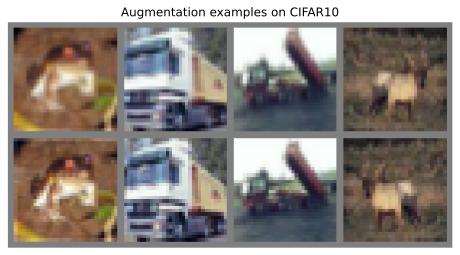

In [9]:
NUM_IMAGES = 4
images = [train_dataset[idx][0] for idx in range(NUM_IMAGES)]
orig_images = [Image.fromarray(train_dataset.data[idx]) for idx in range(NUM_IMAGES)]
orig_images = [test_transform(img) for img in orig_images]

img_grid = torchvision.utils.make_grid(torch.stack(images + orig_images, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Augmentation examples on CIFAR10")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

# PyTorch Lightning

Di notebook ini, kami akan menggunakan library PyTorch Lightning . PyTorch Lightning adalah kerangka kerja yang menyederhanakan kode yang Anda perlukan untuk melatih, mengevaluasi, dan menguji model di PyTorch. Ini juga menangani login ke TensorBoard , toolkit visualisasi untuk eksperimen ML, dan menyimpan model checkpoints secara otomatis dengan overhead kode minimal dari pihak kami. Ini sangat membantu kami karena kami ingin fokus pada penerapan arsitektur model yang berbeda dan menghabiskan sedikit waktu untuk overhead kode lainnya. Perhatikan bahwa pada saat penulisan/pengajaran, kerangka kerja telah dirilis dalam versi 1.3. Versi mendatang mungkin memiliki antarmuka yang sedikit berubah dan dengan demikian mungkin tidak berfungsi sempurna dengan kode (kami akan mencoba untuk tetap memperbaruinya sebanyak mungkin).

Sekarang, kita akan mengambil langkah pertama di PyTorch Lightning, dan melanjutkan menjelajahi kerangka kerja di tutorial kami yang lain. Pertama, kami mengimpor library:

In [10]:
# PyTorch Lightning
import pytorch_lightning as pl

PyTorch Lightning hadir dengan banyak fungsi yang berguna, seperti satu untuk menyetel seed:

In [11]:
# Setting the seed
# Fungsi yang menetapkan seed untuk generator nomor pseudo-acak di: pytorch, numpy, python.random Selain itu, setel variabel lingkungan
pl.seed_everything(42)

Global seed set to 42


42

Dengan demikian, di masa depan, kita tidak perlu lagi mendefinisikan set_seedfungsi kita sendiri.

Di PyTorch Lightning, kami mendefinisikan pl.LightningModule's (mewarisi dari torch.nn.Module) yang mengatur kode kami menjadi 5 bagian utama:

1. Initialization (__init__), di mana kita membuat semua parameter/model yang diperlukan

2. Optimizers (configure_optimizers), tempat kami membuat optimizers, learning rate scheduler, dll.

3. Training loop (training_step), di mana kita hanya perlu mendefinisikan loss calculation untuk satu batch (loop optimizer.zero_grad(), loss.backward() dan optimizer.step(), serta operasi logging/saving apa pun, sudah selesai di background)

4. Validation loop (validation_step), di mana mirip dengan pelatihan, kita hanya perlu menentukan apa yang harus terjadi per langkah

5. Test loop (test_step), yang sama dengan validasi, hanya pada test set.

Oleh karena itu, kami tidak mengabstraksi kode PyTorch, melainkan mengaturnya dan mendefinisikan beberapa operasi default yang umum digunakan. Jika Anda perlu mengubah sesuatu yang lain dalam loop pelatihan/validasi/pengujian Anda, ada banyak kemungkinan fungsi yang dapat Anda timpa (lihat dokumen untuk detailnya).

Sekarang kita dapat melihat contoh bagaimana Lightning Module untuk pelatihan CNN terlihat seperti:

In [12]:
class CIFARModule(pl.LightningModule):

    def __init__(self, model_name, model_hparams, optimizer_name, optimizer_hparams):
        """
        Inputs:
            model_name - Name of the model/CNN to run. Used for creating the model (see function below)
            model_hparams - Hyperparameters for the model, as dictionary.
            optimizer_name - Name of the optimizer to use. Currently supported: Adam, SGD
            optimizer_hparams - Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
        """
        # mengembalikan objek yang mewakili parent class atau memanggil parent class
        super().__init__()
        # call this to save (model_name, model_hparams, optimizer_name, optimizer_hparams) to the checkpoint
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()
        # Create model
        self.model = create_model(model_name, model_hparams)
        # Create loss module
        self.loss_module = nn.CrossEntropyLoss()
        # Example input for visualizing the graph in Tensorboard
        self.example_input_array = torch.zeros((1, 3, 32, 32), dtype=torch.float32)

    def forward(self, imgs):
        # Forward function that is run when visualizing the graph
        return self.model(imgs)

    def configure_optimizers(self):
        # We will support Adam or SGD as optimizers.
        if self.hparams.optimizer_name == "Adam":
            # AdamW is Adam with a correct implementation of weight decay (see here for details: https://arxiv.org/pdf/1711.05101.pdf)
            optimizer = optim.AdamW(
                self.parameters(), **self.hparams.optimizer_hparams)
        elif self.hparams.optimizer_name == "SGD":
            optimizer = optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
        else:
            assert False, f"Unknown optimizer: \"{self.hparams.optimizer_name}\""

        # We will reduce the learning rate by 0.1 after 100 and 150 epochs
        scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        # Calculate acc
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss)
        return loss  # Return tensor to call ".backward" on

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        # Mengembalikan indeks dari nilai maksimum semua elemen dalam tensor input.
        preds = self.model(imgs).argmax(dim=-1)
        # Calculate acc
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        # Calculate acc
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches), and returns it afterwards
        self.log('test_acc', acc)

Kami melihat bahwa kode tersebut terorganisir dan jelas, yang membantu jika orang lain mencoba memahami kode Anda.

Bagian penting lainnya dari PyTorch Lightning adalah konsep callback. Callback adalah fungsi mandiri yang berisi logika non-esensial dari Lightning Module Anda. Mereka biasanya dipanggil setelah menyelesaikan pelatihan epoch, tetapi juga dapat memengaruhi bagian lain dari lingkaran pelatihan Anda. Misalnya, kami akan menggunakan dua callback yang telah ditentukan sebelumnya: LearningRateMonitordan ModelCheckpoint. Monitor learning rate menambahkan learning rate saat ini ke TensorBoard kami, yang membantu memverifikasi bahwa penjadwal learning rate kami berfungsi dengan benar. Model checkpoint callback memungkinkan Anda untuk menyesuaikan rutinitas penyimpanan checkpoints Anda. Misalnya, berapa banyak checkpoints yang harus disimpan, kapan harus disimpan, metrik mana yang harus diperhatikan, dll. Kami mengimpornya di bawah ini:

In [13]:
# Callbacks 
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

Untuk memungkinkan menjalankan beberapa model berbeda dengan modul Lightning yang sama, kami mendefinisikan fungsi di bawah ini yang memetakan nama model ke kelas model. Pada tahap ini, dictionary model_dict, tetapi kami akan mengisinya di seluruh buku catatan dengan model baru kami.

In [14]:
model_dict = {}

def create_model(model_name, model_hparams):
    if model_name in model_dict:
        return model_dict[model_name](**model_hparams)
    else:
        assert False, f"Unknown model name \"{model_name}\". Available models are: {str(model_dict.keys())}"

Demikian pula, untuk menggunakan fungsi aktivasi sebagai hyperparameter lain dalam model kami, kami mendefinisikan dict "nama function" di bawah ini:

In [15]:
# Activation Functions
act_fn_by_name = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "leakyrelu": nn.LeakyReLU,
    "gelu": nn.GELU
}

Jika kita meneruskan kelas atau objek secara langsung sebagai argumen ke modul Lightning, kita tidak dapat memanfaatkan penyimpanan dan pemuatan hyperparameter PyTorch Lightning secara otomatis.

Selain modul Lightning, modul terpenting kedua di PyTorch Lightning adalah Trainer. Pelatih bertanggung jawab untuk melaksanakan langkah-langkah pelatihan yang ditentukan dalam modul Lightning dan menyelesaikan kerangka kerja. Mirip dengan modul Lightning, Anda dapat mengganti bagian penting apa pun yang tidak ingin Anda otomatisasi, tetapi pengaturan default sering kali merupakan praktik terbaik untuk dilakukan. Untuk gambaran lengkap, lihat dokumentasi . Fungsi terpenting yang kami gunakan di bawah ini adalah:

- trainer.fit: Mengambil input modul lightning, dataset pelatihan, dan dataset validasi (opsional). Fungsi ini melatih modul yang diberikan pada dataset pelatihan dengan validasi sesekali (default sekali per epoch, dapat diubah)

- trainer.test: Mengambil model dan set data yang ingin kita uji sebagai input. Ini mengembalikan metrik pengujian pada dataset.

Untuk pelatihan dan pengujian, kita tidak perlu khawatir tentang hal-hal seperti menyetel model ke mode eval ( model.eval()) karena ini semua dilakukan secara otomatis. Lihat di bawah bagaimana kami mendefinisikan fungsi pelatihan untuk model kami:

In [16]:
def train_model(model_name, save_name=None, **kwargs):
    """
    Inputs:
        model_name - Name of the model you want to run. Is used to look up the class in "model_dict"
        save_name (optional) - If specified, this name will be used for creating the checkpoint and logging directory.
    """
    if save_name is None:
        save_name = model_name
        
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),                          # Where to save models
                         gpus=1 if str(device)=="cuda:0" else 0,                                             # We run on a single GPU (if possible)
                         max_epochs=180,                                                                     # How many epochs to train for if no patience is set
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
                                    LearningRateMonitor("epoch")],                                           # Log learning rate every epoch
                         progress_bar_refresh_rate=1)                                                        # In case your notebook crashes due to the progress bar, consider increasing the refresh rate
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
    
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, save_name + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = CIFARModule.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42) # To be reproducable
        model = CIFARModule(model_name=model_name, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = CIFARModule.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training
        
    # Test best model on validation and test set
    val_result = trainer.test(model, dataloaders=val_loader, verbose=False) # model : The model to test, DataLoaders : LightningDataModule yang menentukan sampel uji, verbose : If false, dont prints the test results.
    test_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}
    
    return model, result

# Inception

Blok Inception menerapkan empat blok konvolusi secara terpisah pada peta fitur yang sama: konvolusi 1x1, 3x3, dan 5x5, dan operasi dictionary maks pool. Ini memungkinkan jaringan untuk melihat data yang sama dengan bidang reseptif yang berbeda. Tentu saja, mempelajari konvolusi 5x5 saja secara teoritis akan lebih kuat. Namun, ini tidak hanya lebih banyak komputasi dan memori, tetapi juga cenderung lebih mudah digunakan. Blok awal keseluruhan terlihat seperti di bawah ini (figure credit - Szegedy et al. ):

Konvolusi 1x1 tambahan sebelum konvolusi 3x3 dan 5x5 digunakan untuk reduksi dimensi. Ini sangat penting karena peta fitur dari semua cabang digabungkan setelahnya, dan kami tidak ingin ada ledakan ukuran fitur. Karena konvolusi 5x5 25 kali lebih mahal daripada konvolusi 1x1, kami dapat menghemat banyak komputasi dan parameter dengan mengurangi dimensi sebelum konvolusi besar.

Sekarang kita dapat mencoba mengimplementasikan Inception Block sendiri:

In [17]:
class InceptionBlock(nn.Module):
    
    def __init__(self, c_in, c_red : dict, c_out : dict, act_fn):
        """
        Inputs:
            c_in - Number of input feature maps from the previous layers
            c_red - Dictionary with keys "3x3" and "5x5" specifying the output of the dimensionality reducing 1x1 convolutions
            c_out - Dictionary with keys "1x1", "3x3", "5x5", and "max"
            act_fn - Activation class constructor (e.g. nn.ReLU)
        """
        super().__init__()
        
        # 1x1 convolution branch
        self.conv_1x1 = nn.Sequential(
            nn.Conv2d(c_in, c_out["1x1"], kernel_size=1),
            nn.BatchNorm2d(c_out["1x1"]),
            act_fn()
        )
        
        # 3x3 convolution branch
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(c_in, c_red["3x3"], kernel_size=1),
            nn.BatchNorm2d(c_red["3x3"]),
            act_fn(),
            nn.Conv2d(c_red["3x3"], c_out["3x3"], kernel_size=3, padding=1),
            nn.BatchNorm2d(c_out["3x3"]),
            act_fn()
        )
        
        # 5x5 convolution branch
        self.conv_5x5 = nn.Sequential(
            nn.Conv2d(c_in, c_red["5x5"], kernel_size=1),
            nn.BatchNorm2d(c_red["5x5"]),
            act_fn(),
            nn.Conv2d(c_red["5x5"], c_out["5x5"], kernel_size=5, padding=2),
            nn.BatchNorm2d(c_out["5x5"]),
            act_fn()
        )
        
        # Max-pool branch
        self.max_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            nn.Conv2d(c_in, c_out["max"], kernel_size=1),
            nn.BatchNorm2d(c_out["max"]),
            act_fn()
        )

    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_3x3 = self.conv_3x3(x)
        x_5x5 = self.conv_5x5(x)
        x_max = self.max_pool(x)
        x_out = torch.cat([x_1x1, x_3x3, x_5x5, x_max], dim=1)
        return x_out

Arsitektur GoogleNet terdiri dari menumpuk beberapa blok Inception dengan max pooling sesekali untuk mengurangi tinggi dan lebar peta fitur. GoogleNet asli dirancang untuk ukuran gambar ImageNet (224x224 piksel) dan memiliki hampir 7 juta parameter. Saat kami berlatih di CIFAR10 dengan ukuran gambar 32x32, kami tidak memerlukan arsitektur yang berat, dan sebaliknya, menerapkan versi yang lebih kecil. Jumlah saluran untuk pengurangan dimensi dan keluaran per filter (1x1, 3x3, 5x5, dan pooling maks) perlu ditentukan secara manual dan dapat diubah jika tertarik. Intuisi umumnya adalah memiliki filter terbanyak untuk konvolusi 3x3, karena filter tersebut cukup kuat untuk mempertimbangkan konteks sementara membutuhkan hampir sepertiga dari parameter konvolusi 5x5.

In [18]:
class GoogleNet(nn.Module):

    def __init__(self, num_classes=10, act_fn_name="relu", **kwargs):
        super().__init__()
        self.hparams = SimpleNamespace(num_classes=num_classes,
                                       act_fn_name=act_fn_name,
                                       act_fn=act_fn_by_name[act_fn_name])
        self._create_network()
        self._init_params()

    def _create_network(self):
        # A first convolution on the original image to scale up the channel size
        self.input_net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            self.hparams.act_fn()
        )
        # Stacking inception blocks
        self.inception_blocks = nn.Sequential(
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=self.hparams.act_fn),
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.hparams.act_fn),
            nn.MaxPool2d(3, stride=2, padding=1),  # 32x32 => 16x16
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}, act_fn=self.hparams.act_fn),
            nn.MaxPool2d(3, stride=2, padding=1),  # 16x16 => 8x8
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn)
        )
        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, self.hparams.num_classes)
        )

    def _init_params(self):
        # Based on our discussion in Tutorial 4, we should initialize the convolutions according to the activation function
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.inception_blocks(x)
        x = self.output_net(x)
        return x

Sekarang, kita dapat mengintegrasikan model kita ke modeldict yang kita definisikan di atas:

In [19]:
model_dict["GoogleNet"] = GoogleNet

Pelatihan model ditangani oleh PyTorch Lightning, dan kita hanya perlu mendefinisikan perintah untuk memulai. Perhatikan bahwa kami berlatih selama hampir 200 epoch, yang memakan waktu sekitar satu jam pada GPU default Lisa (GTX1080Ti). Kami akan merekomendasikan menggunakan model yang disimpan dan melatih model Anda sendiri jika Anda tertarik.

In [20]:
googlenet_model, googlenet_results = train_model(model_name="GoogleNet", 
                                                 model_hparams={"num_classes": 10, 
                                                                "act_fn_name": "relu"}, 
                                                 optimizer_name="Adam",
                                                 optimizer_hparams={"lr": 1e-3,
                                                                    "weight_decay": 1e-4})

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model at ../saved_models/tutorial5/GoogleNet.ckpt, loading...


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

Kami akan membandingkan hasilnya nanti di notebook, tapi kami sudah bisa mencetaknya di sini untuk pertama kalinya:

In [21]:
print("GoogleNet Results", googlenet_results)

GoogleNet Results {'test': 0.8970000147819519, 'val': 0.9039999842643738}


# Tensorboard log

Tambahan yang bagus dari PyTorch Lightning adalah login otomatis ke TensorBoard. Untuk memberi Anda intuisi yang lebih baik tentang apa yang dapat digunakan TensorBoard, kita dapat melihat board yang telah dibuat oleh PyTorch Lightning saat melatih GoogleNet. TensorBoard menyediakan fungsionalitas sebaris untuk notebook Jupyter, dan kami menggunakannya di sini:

In [22]:
# Load tensorboard extension
%load_ext tensorboard

In [23]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH!
%tensorboard --logdir ../saved_models/tutorial5/tensorboards/GoogleNet/

Reusing TensorBoard on port 6006 (pid 220), started 0:01:23 ago. (Use '!kill 220' to kill it.)

<IPython.core.display.Javascript object>

TensorBoard diatur dalam beberapa tab. Tab utama adalah tab skalar tempat kita dapat mencatat perkembangan bilangan tunggal. Sebagai contoh, kita telah memplot training loss, akurasi, learning rate, dll. Jika kita melihat akurasi training atau validasi, kita benar-benar dapat melihat dampak penggunaan learning rate scheduler. Mengurangi tingkat pembelajaran memberi model kami peningkatan yang bagus dalam kinerja pelatihan. Demikian pula, ketika melihat kerugian pelatihan, kami melihat penurunan mendadak pada titik ini. Namun, angka yang tinggi pada set pelatihan dibandingkan dengan validasi menunjukkan bahwa model kami overfitting yang tidak dapat dihindari untuk jaringan sebesar itu.

Tab menarik lainnya di TensorBoard adalah tab grafik. Ini menunjukkan kepada kita arsitektur jaringan yang diatur oleh blok bangunan dari input ke output. Ini pada dasarnya menunjukkan operasi yang diambil dalam langkah maju dari CIFARModule. Klik dua kali pada modul untuk membukanya. Jangan ragu untuk menjelajahi arsitektur dari perspektif yang berbeda. Visualisasi grafik seringkali dapat membantu Anda untuk memvalidasi bahwa model Anda benar-benar melakukan apa yang seharusnya dilakukan, dan Anda tidak melewatkan lapisan apa pun dalam grafik komputasi.

# ResNet

ResNet (Residual Network) adalah salah satu paper AI yang banyak dikutip dan telah menjadi dasar untuk jaringan saraf yang sangat dalam dengan lebih dari 1000 lapisan. Terlepas dari itu, ide koneksi residual juga sangat efektif karena mendukung propagasi gradien yang stabil melalui jaringan.Kita juga memodelkan pemetaan non-linear(biasanya urutan modul NN seperti konvolusi, fungsi aktivasi, dan normalisasi).

Bias terhadap matriks identitas menjamin propagasi gradien yang stabil menjadi kurang dipengaruhi oleh ***F*** itu sendiri. Ada banyak varian ResNet yang diusulkan, yang sebagian besar menyangkut fungsi ***F*** , atau operasi yang diterapkan pada penjumlahan. Dalam tutorial ini, kita melihat dua di antaranya: blok ResNet asli, dan blok ResNet Pra-Aktivasi.

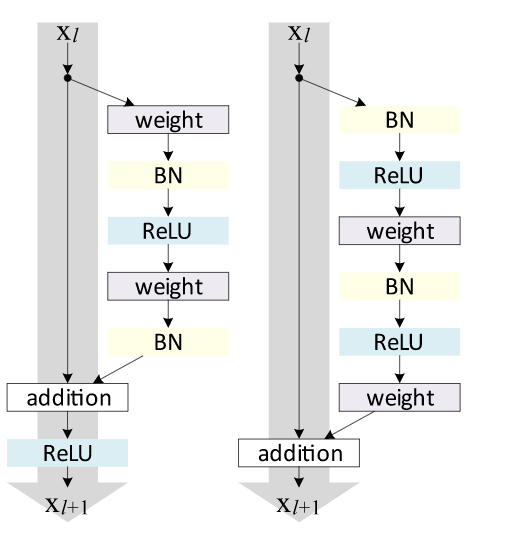

Blok ResNet asli menerapkan fungsi aktivasi non-linear, biasanya ReLU, setelah koneksi lewati. Sebaliknya, blok ResNet pra-aktivasi menerapkan non-linearitas di awal **F**. Keduanya memiliki kelebihan dan kekurangan. Namun, untuk jaringan yang sangat dalam, pra-aktivasi ResNet telah menunjukkan kinerja yang lebih baik karena aliran gradien dijamin memiliki matriks identitas seperti yang dihitung di atas, dan tidak dirugikan oleh aktivasi non-linear yang diterapkan padanya. Sebagai perbandingan, di notebook ini, kami menerapkan kedua jenis ResNet sebagai jaringan dangkal.

Pertama kita akan mengimplementasikan dengan blok ResNet asli. Visualisasi di atas sudah menunjukkan lapisan apa saja yang termasuk dalam . Satu kasus khusus yang harus kita tangani adalah ketika kita ingin mengurangi dimensi gambar dalam hal lebar dan tinggi

In [24]:
class ResNetBlock(nn.Module):

    def __init__(self, c_in, act_fn, subsample=False, c_out=-1):
        """
        Inputs:
            c_in - Number of input features
            act_fn - Activation class constructor (e.g. nn.ReLU)
            subsample - If True, we want to apply a stride inside the block and reduce the output shape by 2 in height and width
            c_out - Number of output features. Note that this is only relevant if subsample is True, as otherwise, c_out = c_in
        """
        #Mengembalikan atribut dari super objek (induk) suatu kelas
        super().__init__()
        if not subsample:
            c_out = c_in
            
        # Network representing F
        self.net = nn.Sequential(
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1, stride=1 if not subsample else 2, bias=False),  # No bias needed as the Batch Norm handles it
            nn.BatchNorm2d(c_out),
            act_fn(),
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(c_out)
        )
        
        # 1x1 convolution with stride 2 means we take the upper left value, and transform it to new output size
        self.downsample = nn.Conv2d(c_in, c_out, kernel_size=1, stride=2) if subsample else None
        self.act_fn = act_fn()

    def forward(self, x):
        z = self.net(x)
        if self.downsample is not None:
            x = self.downsample(x)
        out = z + x
        out = self.act_fn(out)
        return out

Blok kedua yang kita terapkan adalah blok ResNet pra-aktivasi. Untuk ini, kita harus mengubah urutan layer di self.net, dan tidak menerapkan fungsi aktivasi pada output. Selain itu, operasi downsampling harus menerapkan non-linearitas serta input, , belum diproses oleh non-linearitas. Oleh karena itu, blok terlihat sebagai berikut:

In [25]:
class PreActResNetBlock(nn.Module):

    def __init__(self, c_in, act_fn, subsample=False, c_out=-1):
        """
        Inputs:
            c_in - Number of input features
            act_fn - Activation class constructor (e.g. nn.ReLU)
            subsample - If True, we want to apply a stride inside the block and reduce the output shape by 2 in height and width
            c_out - Number of output features. Note that this is only relevant if subsample is True, as otherwise, c_out = c_in
        """
        super().__init__()
        if not subsample:
            c_out = c_in
            
        # Network representing F
        self.net = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1, stride=1 if not subsample else 2, bias=False),
            nn.BatchNorm2d(c_out),
            act_fn(),
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1, bias=False)
        )
        
        # 1x1 convolution needs to apply non-linearity as well as not done on skip connection
        self.downsample = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=1, stride=2, bias=False)
        ) if subsample else None

    def forward(self, x):
        z = self.net(x)
        if self.downsample is not None:
            x = self.downsample(x)
        out = z + x
        return out

Sama halnya dengan pemilihan model, kita mendefinisikan untuk membuat pemetaan dari kelas string ke blok. Kita akan menggunakan nama string sebagai nilai hyperparameter dalam model kita untuk memilih di antara blok ResNet.

In [26]:
resnet_blocks_by_name = {
    "ResNetBlock": ResNetBlock,
    "PreActResNetBlock": PreActResNetBlock
}

Arsitektur ResNet keseluruhan terdiri dari penumpukan beberapa blok ResNet, di mana beberapa di antaranya melakukan downsampling input. Ketika berbicara tentang blok ResNet di seluruh jaringan, kami biasanya mengelompokkannya berdasarkan bentuk keluaran yang sama. Oleh karena itu, jika kita mengatakan ResNet memiliki [3,3,3] blok, itu berarti bahwa kita memiliki 3 kali kelompok 3 blok ResNet, di mana subsampling terjadi di blok keempat dan ketujuh. ResNet dengan [3,3,3] blok di CIFAR10 divisualisasikan di bawah ini.

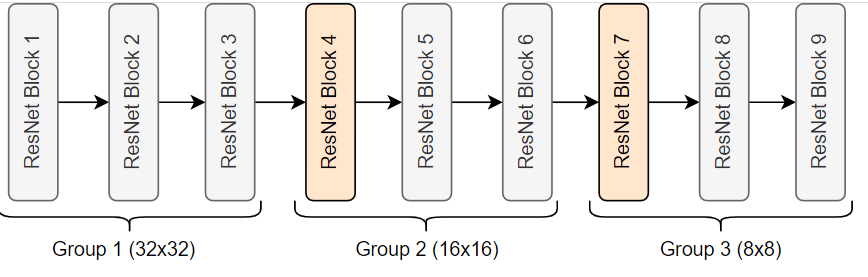

Tiga kelompok beroperasi pada resolusi **32 X 32 16 X 16 dan 8 X 8** masing-masing. Blok berwarna oranye menunjukkan blok ResNet dengan downsampling. Notasi yang sama digunakan oleh banyak implementasi lain seperti di perpustakaan torchvision dari PyTorch. Jadi, kode kita terlihat sebagai berikut:

In [27]:
class ResNet(nn.Module):

    def __init__(self, num_classes=10, num_blocks=[3,3,3], c_hidden=[16,32,64], act_fn_name="relu", block_name="ResNetBlock", **kwargs):
        """
        Inputs: 
            num_classes - Number of classification outputs (10 for CIFAR10)
            num_blocks - List with the number of ResNet blocks to use. The first block of each group uses downsampling, except the first.
            c_hidden - List with the hidden dimensionalities in the different blocks. Usually multiplied by 2 the deeper we go.
            act_fn_name - Name of the activation function to use, looked up in "act_fn_by_name"
            block_name - Name of the ResNet block, looked up in "resnet_blocks_by_name"
        """
        super().__init__()
        assert block_name in resnet_blocks_by_name
        self.hparams = SimpleNamespace(num_classes=num_classes, 
                                       c_hidden=c_hidden, 
                                       num_blocks=num_blocks, 
                                       act_fn_name=act_fn_name,
                                       act_fn=act_fn_by_name[act_fn_name],
                                       block_class=resnet_blocks_by_name[block_name])
        self._create_network()
        self._init_params()

    def _create_network(self):
        c_hidden = self.hparams.c_hidden
        
        # A first convolution on the original image to scale up the channel size
        if self.hparams.block_class == PreActResNetBlock: # => Don't apply non-linearity on output
            self.input_net = nn.Sequential(
                nn.Conv2d(3, c_hidden[0], kernel_size=3, padding=1, bias=False)
            )
        else:
            self.input_net = nn.Sequential(
                nn.Conv2d(3, c_hidden[0], kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(c_hidden[0]),
                self.hparams.act_fn()
            )
        
        # Creating the ResNet blocks
        blocks = []
        for block_idx, block_count in enumerate(self.hparams.num_blocks):
            for bc in range(block_count):
                subsample = (bc == 0 and block_idx > 0) # Subsample the first block of each group, except the very first one.
                blocks.append(
                    self.hparams.block_class(c_in=c_hidden[block_idx if not subsample else (block_idx-1)],
                                             act_fn=self.hparams.act_fn,
                                             subsample=subsample,
                                             c_out=c_hidden[block_idx])
                )
        self.blocks = nn.Sequential(*blocks)
        
        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(c_hidden[-1], self.hparams.num_classes)
        )

    def _init_params(self):
        # Based on our discussion in Tutorial 4, we should initialize the convolutions according to the activation function
        # Fan-out focuses on the gradient distribution, and is commonly used in ResNets
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.blocks(x)
        x = self.output_net(x)
        return x

In [28]:
#Menambahkan ResNet ke model dictionary
model_dict["ResNet"] = ResNet

Akhirnya, kita dapat melatih model ResNet kita. Satu perbedaan pada pelatihan GoogleNet adalah bahwa kami secara eksplisit menggunakan SGD dengan Momentum sebagai pengoptimal, bukan Adam. Adam sering menghasilkan akurasi yang sedikit lebih buruk pada ResNets yang sederhana dan dangkal. Tidak 100% jelas mengapa kinerja Adam lebih buruk dalam konteks ini, tetapi satu penjelasan yang mungkin terkait dengan permukaan kerugian ResNet. ResNet telah terbukti menghasilkan permukaan kerugian yang lebih halus daripada jaringan tanpa melewatkan koneksi.

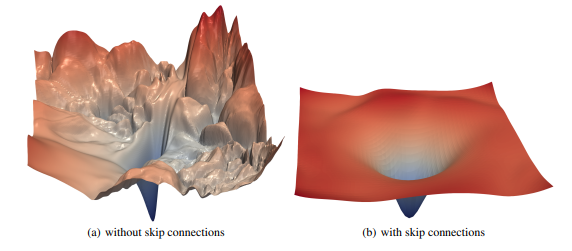

Sumbu x dan y menunjukkan proyeksi ruang parameter, dan sumbu menunjukkan nilai kerugian yang dicapai oleh nilai parameter yang berbeda. Pada permukaan halus seperti yang ada di sebelah kanan, kita mungkin tidak memerlukan tingkat pembelajaran adaptif seperti yang disediakan Adam. Sebaliknya, Adam bisa terjebak di local optima sementara SGD menemukan minima yang lebih luas yang cenderung menggeneralisasi lebih baik. Namun, untuk menjawab pertanyaan ini secara mendetail, kita membutuhkan tutorial tambahan karena tidak mudah untuk menjawabnya. Untuk saat ini, kami menyimpulkan: untuk arsitektur ResNet, anggap pengoptimal sebagai hyperparameter penting, dan coba pelatihan dengan Adam dan SGD.

In [29]:
resnet_model, resnet_results = train_model(model_name="ResNet", 
                                           model_hparams={"num_classes": 10,
                                                          "c_hidden": [16,32,64],
                                                          "num_blocks": [3,3,3],
                                                          "act_fn_name": "relu"}, 
                                           optimizer_name="SGD",
                                           optimizer_hparams={"lr": 0.1,
                                                              "momentum": 0.9,
                                                              "weight_decay": 1e-4})

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model at ../saved_models/tutorial5/ResNet.ckpt, loading...


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

Selanjutnya kita juga melatih ResNet pra-aktivasi sebagai perbandingan:

In [30]:
resnetpreact_model, resnetpreact_results = train_model(model_name="ResNet", 
                                                       model_hparams={"num_classes": 10,
                                                                      "c_hidden": [16,32,64],
                                                                      "num_blocks": [3,3,3],
                                                                      "act_fn_name": "relu",
                                                                      "block_name": "PreActResNetBlock"}, 
                                                       optimizer_name="SGD",
                                                       optimizer_hparams={"lr": 0.1,
                                                                          "momentum": 0.9,
                                                                          "weight_decay": 1e-4},
                                                       save_name="ResNetPreAct")

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model at ../saved_models/tutorial5/ResNetPreAct.ckpt, loading...


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

# Tensorboard log

In [31]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH! Feel free to change "ResNet" to "ResNetPreAct"
%tensorboard --logdir ../saved_models/tutorial5/tensorboards/ResNet/

Reusing TensorBoard on port 6007 (pid 282), started 0:01:20 ago. (Use '!kill 282' to kill it.)

<IPython.core.display.Javascript object>

# 3. DenseNet

DenseNet adalah arsitektur lain untuk mengaktifkan neural network yang sangat dalam dan mengambil perspektif yang sedikit berbeda pada residual connections. Alih-alih memodelkan perbedaan antar lapisan, DenseNet menganggap residual connections sebagai cara yang memungkinkan untuk menggunakan kembali fitur di seluruh lapisan/layer, menghilangkan keperluan apa pun untuk mempelajari peta fitur yang berlebihan. Jika kita masuk lebih dalam ke jaringan/network, model mempelajari fitur abstrak untuk mengenali pola. Namun, beberapa pola kompleks terdiri dari kombinasi fitur abstrak (misalnya tangan, wajah, dll.), dan fitur low-level (misalnya tepi, warna dasar, dll.). Untuk menemukan fitur low-level ini di layer dalam, CNN standar harus belajar menyalin peta fitur tersebut, yang membuang banyak kompleksitas parameter. DenseNet menyediakan cara yang efisien untuk menggunakan kembali fitur dengan membuat setiap konvolusi bergantung pada semua fitur input sebelumnya, tetapi hanya menambahkan sedikit filter ke dalamnya. Lihat gambar di bawah untuk ilustrasi (gambar kredit - Hu dkk):

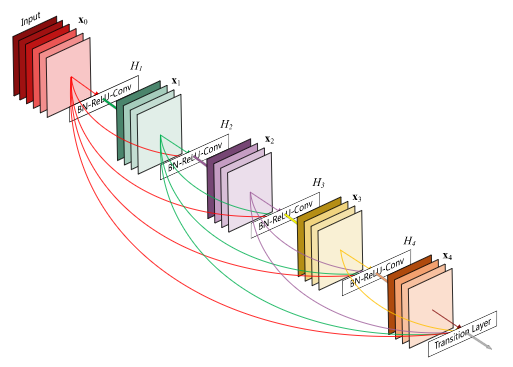

Kelebihan lain DenseNet adalah meringankan masalah gradien-gradien, memperkuat penyebaran fitur, mendorong penggunaan kembali fitur, dan secara substansial mengurangi jumlah parameter.

Layer terakhir, yang disebut Transition Layer, bertanggung jawab untuk mengurangi dimensi peta fitur dalam tinggi, lebar, dan ukuran channel. Meskipun secara teknis akan merusak identitas backpropagation, namun hanya ada beberapa backpropagation di jaringan sehingga tidak banyak mempengaruhi 
gradient flow.
Layer DenseNet dibagi menjadi tiga bagian: DenseLayer, DenseBlock, dan TransitionLayer. Modul DenseLayer mengimplementasikan satu layer di dalam dense block. Ini menerapkan konvolusi 1x1 untuk pengurangan dimensi dengan konvolusi 3x3 berikutnya. Output channel digabungkan ke aslinya sebelum di return. Diterapkan Batch Normalization sebagai layer pertama dari setiap blok. Ini memungkinkan aktivasi yang sedikit berbeda untuk fitur yang sama ke layer yang berbeda, tergantung pada apa yang dibutuhkan.

In [32]:
class DenseLayer(nn.Module):
    
    def __init__(self, c_in, bn_size, growth_rate, act_fn):
        """
        Inputs:
            c_in - Number of input channels
            bn_size - Bottleneck size (factor of growth rate) for the output of the 1x1 convolution. Typically between 2 and 4.
            growth_rate - Number of output channels of the 3x3 convolution
            act_fn - Activation class constructor (e.g. nn.ReLU)
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, bn_size * growth_rate, kernel_size=1, bias=False),
            nn.BatchNorm2d(bn_size * growth_rate),
            act_fn(),
            nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
        )
        
    def forward(self, x):
        out = self.net(x)
        out = torch.cat([out, x], dim=1)
        return out

Modul DenseBlock merangkum beberapa dense layer yang diterapkan secara berurutan. Setiap dense layer mengambil input asli sebagai input yang digabungkan dengan semua peta fitur layer sebelumnya.

In [33]:
class DenseBlock(nn.Module):
    
    def __init__(self, c_in, num_layers, bn_size, growth_rate, act_fn):
        """
        Inputs:
            c_in - Number of input channels
            num_layers - Number of dense layers to apply in the block
            bn_size - Bottleneck size to use in the dense layers
            growth_rate - Growth rate to use in the dense layers
            act_fn - Activation function to use in the dense layers
        """
        super().__init__()
        layers = []
        for layer_idx in range(num_layers):
            layers.append(
                DenseLayer(c_in=c_in + layer_idx * growth_rate, # Input channels are original plus the feature maps from previous layers
                           bn_size=bn_size,
                           growth_rate=growth_rate,
                           act_fn=act_fn)
            )
        self.block = nn.Sequential(*layers)
        
    def forward(self, x):
        out = self.block(x)
        return out

Kemudian TransitionLayer mengambil output akhir dari dense block sebagai input dan mengurangi dimensi channelnya menggunakan konvolusi 1x1. Untuk mengurangi dimensi tinggi dan lebar, diambil pendekatan yang berbeda daripada di ResNet dan menerapkan average pooling (penyatuan rata-rata) dengan ukuran kernel 2 dan stride 2. Ini karena kita tidak memiliki koneksi tambahan ke output yang akan mempertimbangkan patch 2x2 secara penuh, alih-alih tunggal. Selain itu, parameter ini lebih efisien daripada menggunakan konvolusi 3x3 dengan stride 2.

In [34]:
class TransitionLayer(nn.Module):
    
    def __init__(self, c_in, c_out, act_fn):
        super().__init__()
        self.transition = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=1, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2) # Average the output for each 2x2 pixel group
        )
        
    def forward(self, x):
        return self.transition(x)

Sekarang menggabungkan semuanya dan membuat jaringan DenseNet. Untuk menentukan jumlah layer, digunakan notasi yang sama seperti di ResNet dan meneruskan list berisi integer yang mewakili jumlah layer per blok. Setelah setiap dence block kecuali yang terakhir, diterapkan Transition layer untuk mengurangi dimensi sebesar 2.

In [35]:
class DenseNet(nn.Module):
    
    def __init__(self, num_classes=10, num_layers=[6,6,6,6], bn_size=2, growth_rate=16, act_fn_name="relu", **kwargs):
        super().__init__()
        self.hparams = SimpleNamespace(num_classes=num_classes,
                                       num_layers=num_layers,
                                       bn_size=bn_size,
                                       growth_rate=growth_rate,
                                       act_fn_name=act_fn_name,
                                       act_fn=act_fn_by_name[act_fn_name])
        self._create_network()
        self._init_params()
        
    def _create_network(self):
        c_hidden = self.hparams.growth_rate * self.hparams.bn_size # The start number of hidden channels
        
        # A first convolution on the original image to scale up the channel size
        self.input_net = nn.Sequential(
            nn.Conv2d(3, c_hidden, kernel_size=3, padding=1) # No batch norm or activation function as done inside the Dense layers
        )
        
        # Creating the dense blocks, eventually including transition layers
        blocks = []
        for block_idx, num_layers in enumerate(self.hparams.num_layers):
            blocks.append( 
                DenseBlock(c_in=c_hidden, 
                           num_layers=num_layers, 
                           bn_size=self.hparams.bn_size,
                           growth_rate=self.hparams.growth_rate,
                           act_fn=self.hparams.act_fn)
            )
            c_hidden = c_hidden + num_layers * self.hparams.growth_rate # Overall output of the dense block
            if block_idx < len(self.hparams.num_layers)-1: # Don't apply transition layer on last block
                blocks.append(
                    TransitionLayer(c_in=c_hidden,
                                    c_out=c_hidden // 2,
                                    act_fn=self.hparams.act_fn))
                c_hidden = c_hidden // 2
                
        self.blocks = nn.Sequential(*blocks)
        
        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.BatchNorm2d(c_hidden), # The features have not passed a non-linearity until here.
            self.hparams.act_fn(),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(c_hidden, self.hparams.num_classes)
        )

    def _init_params(self):
        # Based on our discussion in Tutorial 4, we should initialize the convolutions according to the activation function
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.blocks(x)
        x = self.output_net(x)
        return x

Menambahkan juga DenseNet ke model dictionary kita:

In [36]:
model_dict["DenseNet"] = DenseNet

Terakhir, melatih model DenseNet. Berbeda dengan ResNet, DenseNet tidak menunjukkan masalah apa pun dengan Adam, dan karenanya modelnya dilatih dengan optimizer ini. Hyperparameter lainnya disetel sama dengan hyperparameter dari model GoogLeNet dan ResNet. Umumnya, ketika merancang network yang sangat dalam, DenseNet merupakan parameter yang lebih efisien daripada ResNet, serta mencapai kinerja yang serupa atau bahkan lebih baik.

In [37]:
densenet_model, densenet_results = train_model(model_name="DenseNet", 
                                               model_hparams={"num_classes": 10,
                                                              "num_layers": [6,6,6,6],
                                                              "bn_size": 2,
                                                              "growth_rate": 16,
                                                              "act_fn_name": "relu"}, 
                                               optimizer_name="Adam",
                                               optimizer_hparams={"lr": 1e-3,
                                                                  "weight_decay": 1e-4})

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model at ../saved_models/tutorial5/DenseNet.ckpt, loading...


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

# Tensorboard log

Kita juga memiliki TensorBoard untuk pelatihan DenseNet.

In [38]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH! Feel free to change "ResNet" to "ResNetPreAct"
%tensorboard --logdir ../saved_models/tutorial5/tensorboards/DenseNet/

Reusing TensorBoard on port 6008 (pid 356), started 0:01:15 ago. (Use '!kill 356' to kill it.)

<IPython.core.display.Javascript object>

# Kesimpulan dan Perbandingan

Setelah membahas setiap model secara terpisah, dan melakukan training, akhirnya kita dapat membandingkannya. Pertama, kita mengaturatur hasil dari semua model kedalam sebuah tabel.

In [39]:
%%html
<!-- Some HTML code to increase font size in the following table -->
<style>
th {font-size: 120%;}
td {font-size: 120%;}
</style>

In [40]:
import tabulate
from IPython.display import display, HTML
all_models = [
    ("GoogleNet", googlenet_results, googlenet_model),
    ("ResNet", resnet_results, resnet_model),
    ("ResNetPreAct", resnetpreact_results, resnetpreact_model),
    ("DenseNet", densenet_results, densenet_model)
]
table = [[model_name,
          f"{100.0*model_results['val']:4.2f}%",
          f"{100.0*model_results['test']:4.2f}%",
          "{:,}".format(sum([np.prod(p.shape) for p in model.parameters()]))]
         for model_name, model_results, model in all_models]
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Model", "Val Accuracy", "Test Accuracy", "Num Parameters"])))

Model,Val Accuracy,Test Accuracy,Num Parameters
GoogleNet,90.40%,89.70%,"260,650"
ResNet,91.84%,91.06%,"272,378"
ResNetPreAct,91.80%,91.07%,"272,250"
DenseNet,90.72%,90.23%,"239,146"


Dapat dilihat bahwa semua model memiliki kinrja yang cukup baik. GoogleNet adalah model untuk mendapatkan kinerja terendah pada set validasi dan test, meskipun sangat dekat dengan DenseNet. Pencarian hyperparameter yang tepat untuk semua ukuran channel di GoogleNet kemungkinan akan meningkatkan akurasi model ke tingkat yang sama, tetapi ini juga mahal mengingat jumlah hyperparameter yang besar. ResNet mengungguli DenseNet dan GoogleNet lebih dari 1% pada set validasi, sementara ada perbedaan kecil antara kedua versi, versi asli dan versi pra-aktivasi. Dari sini kita dapat menyimpulkan bahwa untuk network dangkal, tempat dari fungsi aktivasi tampaknya tidak terlalu penting, meskipun makalah telah melaporkan sebaliknya untuk jaringan yang sangat dalam (misalnya He dkk).

Secara umum, kita dapat menyimpulkan bahwa ResNet adalah arsitektur yang sederhana namun kuat. Jika kita akan menerapkan model pada tugas yang lebih kompleks dengan gambar yang lebih besar serta lebih banyak lapisan dalam network, kemungkinan kita akan melihat kesenjangan yang lebih besar antara GoogleNet dan arsitektur skip-connection seperti ResNet dan DenseNet. Perbandingan dengan model yang lebih dalam di CIFAR10 misalnya dapat ditemukan di sini. Menariknya, DenseNet mengungguli ResNet asli pada pengaturan mereka tetapi berada di belakang ResNet Pra-Aktivasi. Model terbaik, Dual Path Network (Chen dkk), sebenarnya merupakan kombinasi dari ResNet dan DenseNet yang menunjukkan bahwa keduanya menawarkan keuntungan yang berbeda.

# Model mana yang harus saya pilih untuk tugas saya?

Telah ditinjau empat model yang berbeda. Jadi, mana yang harus kita pilih jika telah diberi tugas baru? Biasanya, memulai dengan ResNet adalah ide yang bagus mengingat kinerja yang unggul dari kumpulan data CIFAR dan implementasinya yang sederhana. Selain itu, untuk nomor parameter yang kami pilih di sini, ResNet adalah yang tercepat karena DenseNet dan GoogleNet memiliki lebih banyak lapisan yang diterapkan secara berurutan dalam implementasi primitif. Namun, jika tugasnya sangat sulit, seperti segmentasi semantik pada gambar HD, disarankan menggunakan varian ResNet dan DenseNet yang lebih kompleks.